![](https://www.flyability.com/hs-fs/hubfs/SEO%20content/Commercial%20drones/commercial-drones-parrot-anafi-usa.png?width=1200&name=commercial-drones-parrot-anafi-usa.png)

# Quadcopter Dynamics and Control

by Kevin J. Walchko, Phd

July 2021

---

# References

- YouTube: [Class 6 - Quadrotor Dynamics](https://www.youtube.com/watch?v=UC8W3SfKGmg)
- Matlab: [6DOF (Euler Angles)](https://www.mathworks.com/help/aeroblks/6dofeulerangles.html)

## Simulink Reference

Using the 6DoF block as an idea for how to build my drone model ... not done yet.

![](pics/simulink-block.gif)

![](pics/simulink-frame.png)

## Variables and Units

| Symbol     | Units   | Definition |
|------------|:-------:|:-----------|
| $F_i$      | N       | Force      |
| $\tau_i$   | Nm      | Moment     |
| $\gamma$   | m       | torque/force ratio |
| $n$        | rpm     | motor shaft speed |
| $\omega$   | rad/sec | rotation rate of the drone body $\begin{bmatrix} p & q & r \end{bmatrix}^T$ |
| $L$        | m       | distance from CoM to motor |
| $J$        | $kg.m^2$| rotational inertia |
| $I_m$      | $kg.m^2$| motor inertia |
| $v$        | m/sec   | linear body velocity, $\begin{bmatrix} u & v & w \end{bmatrix}^T$ |


## Motion

The diagram below shows the direction of the propellers spining. By increasing the speed and decreasing the speed of the combinations of motors, the following can be achieved: up, down, roll, pitch, and rotate about z-axis. Note, that the system is under actuated, since there is no direct way to move in the horizontal plane without some combination of roll/pitch first. Thus there is 1 DoF for z-axis translational motion and 3 DoF for rotational motion for a total of 4 DoF.

<table>
    <tr>
        <td> <img src="pics/movement.jpg" width="75%"> </td>
        <td> <img src="pics/torque.jpg"> </td>
    </tr>
</table>

Remeber, the diagrams above show propellor spin direction. Since the propellor is pushing on the air as it spins, this causes the resulting torque transfered to the aircraft frame to be in the opposite direction.

### Motors

$$
F_i = k_F n_i^2 \\
\tau_i = k_M n_i^2 + I_m \dot n_i
$$

So we can simplify the motor torque by with the assumption, the motor speeds are generally constant and only change speeds over a very short time:

$$
\dot n_i \approx 0 \\ 
\tau_i = k_M n_i^2 + I_m \dot n_i \to \tau_i = k_M n_i^2
$$

Also, for deriving equations, since there is a relationship between forces and
torques, we can write:

$$
\frac {\tau_i}{F_i} = \frac {k_M n_i^2}{k_F n_i^2} = \frac {k_M}{k_F} = \gamma \to \tau_i = \gamma F_i
$$

Note that although the motor constants $k_M$ and $k_F$ are shown as constant, they do vary with air density, temperature, friction, etc.


## Dynamics

### Translational

Starting with Newton's Law:

$$
m \frac{dv}{dt} = m \dot v = F \\
$$

Translational motion in the *inertial frame*:

$$
m \dot v =  -m \vec{g} + R^n_b F_T \\
\dot v = -\vec{g} + R^n_b F_T/m \\
F_T = \begin{bmatrix} 0 && 0 && F_1 + F_2 + F_3 + F_4 \end{bmatrix}^T \\
\vec{g} = \begin{bmatrix} 0 && 0 && g \end{bmatrix}^T
$$

where $F_T$ is the thrust vector. Now we can isolate the translational control forces, which control the drone as:

$$
u_1 \equiv F_T
$$

Later, we will use both the translational and rotational control terms in our controller.

### Rotational

Let's start with assuming the drone is symetrical, then the inertia ($J$) is:

$$
J = 
\begin{bmatrix}
  J_x & 0 & 0 \\
  0 & J_y & 0 \\
  0 & 0 & J_z
\end{bmatrix}
$$

Additionally, if we assume the drone is in an X shape, then $J_x = J_y$. However, just in case it isn't because of payload, we won't simplify the equations below. 

Euler's Equation in the *body frame*: 

$$
J \dot \omega + \omega \times (J \omega) = \tau \\
J \dot \omega = \tau - \omega \times (J \omega) \\
\dot \omega = J^{-1}[\tau - \omega \times (J \omega)] \\
\dot \omega = 
  \begin{bmatrix}
    \tau_x/J_x \\
    \tau_y/J_y \\
    \tau_z/J_z \\
  \end{bmatrix} - 
  \begin{bmatrix}
    \frac {J_y - J_z}{J_x} q \cdot r \\
    \frac {J_z - J_x}{J_y} p \cdot r \\
    \frac {J_x - J_y}{J_z} p \cdot q \\
  \end{bmatrix}
$$

where $\omega^b = \begin{bmatrix} p & q & r \end{bmatrix}^T$. Now calculating the control moments by rearranging and substituting in $\tau_i = \gamma F_i$:

$$
u_2 \equiv \tau = 
\begin{bmatrix} 
  L(F_2-F_4) \\
  L(F_3-F_1) \\
  \tau_1 - \tau_2 + \tau_3 - \tau_4
\end{bmatrix} =
\begin{bmatrix} 
  0 & L & 0 & -L \\
  -L & 0 & L & 0 \\
  \gamma & -\gamma & \gamma & -\gamma
\end{bmatrix}\begin{bmatrix} F_1 \\ F_2 \\ F_3 \\ F_4 \end{bmatrix}
$$

## Control

Now you can define your control input as a combination of motor forces, motor locations, and force/torque ratios:

$$
u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} =
\begin{bmatrix} 
  1 & 1 & 1 & 1 \\
  0 & L & 0 & -L \\
  -L & 0 & L & 0 \\
  \gamma & -\gamma & \gamma & -\gamma
\end{bmatrix}
\begin{bmatrix} F_1 \\ F_2 \\ F_3 \\ F_4 \end{bmatrix} = 
\begin{bmatrix} thrust \\ moment_x \\ moment_y \\ moment_z \end{bmatrix}
$$

$$
u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} =
k_f\begin{bmatrix} 
  1 & 1 & 1 & 1 \\
  0 & L & 0 & -L \\
  -L & 0 & L & 0 \\
  \gamma & -\gamma & \gamma & -\gamma
\end{bmatrix}
\begin{bmatrix} n_1^2 \\ n_2^2 \\ n_3^2 \\ n_4^2 \end{bmatrix} = 
\begin{bmatrix} thrust \\ moment_x \\ moment_y \\ moment_z \end{bmatrix}
$$

## Rate of Change for Euler Angles

To update the orientation of the quadcopter, you *could* use the following relationship.

$$
\begin{bmatrix} \dot \phi \\ \dot \theta \\ \dot \psi \end{bmatrix} = 
\begin{bmatrix} 
    1 && \sin \phi \tan \theta && \cos \phi \tan \theta \\
    0 && \cos \phi && -\sin \phi \\
    0 && \sin \phi \sec \theta && \cos \phi \sec \theta
\end{bmatrix}
\begin{bmatrix} p \\ q \\ r \end{bmatrix}
$$

where $\theta \ne \pi/2$ and if both $\phi$ and $\theta$ are close to 0 (when quadcopter is hovering), then the matrix becomes the identify matrix. Integrating Euler angles using the above can lead to issues, so typically you choose to use quaternions instead.

$$
\dot q = \frac {1}{2} q \otimes \omega
$$

## SciPy Integration

`solve_ivp` can use various methods to perform integration.

- **method:** string or OdeSolver, *optional*

    - ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4) [1]. The error is controlled assuming accuracy of the fourth-order method, but steps are taken using the fifth-order accurate formula (local extrapolation is done). A quartic interpolation polynomial is used for the dense output [2]. Can be applied in the complex domain.

    - ‘RK23’: Explicit Runge-Kutta method of order 3(2) [3]. The error is controlled assuming accuracy of the second-order method, but steps are taken using the third-order accurate formula (local extrapolation is done). A cubic Hermite polynomial is used for the dense output. Can be applied in the complex domain.

    - ‘DOP853’: Explicit Runge-Kutta method of order 8 [13]. Python implementation of the “DOP853” algorithm originally written in Fortran [14]. A 7-th order interpolation polynomial accurate to 7-th order is used for the dense output. Can be applied in the complex domain.

    - ‘Radau’: Implicit Runge-Kutta method of the Radau IIA family of order 5 [4]. The error is controlled with a third-order accurate embedded formula. A cubic polynomial which satisfies the collocation conditions is used for the dense output.

    - ‘BDF’: Implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation [5]. The implementation follows the one described in [6]. A quasi-constant step scheme is used and accuracy is enhanced using the NDF modification. Can be applied in the complex domain.

    - ‘LSODA’: Adams/BDF method with automatic stiffness detection and switching [7], [8]. This is a wrapper of the Fortran solver from ODEPACK.

```
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 8
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.    , 0.0001])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -6.07867133e-12],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.21573427e-07],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])
 y_events: None
```

In [55]:
import numpy as np
import simplejson as json
from matplotlib import pyplot as plt
from collections import deque
from math import sin, pi

In [18]:
from scipy.integrate import odeint, solve_ivp as rk45
from squaternion import Quaternion
from pprint import pprint

In [205]:
rpm2w = 2*np.pi/60
w2rpm = 60/2/np.pi

In [206]:
# AR drone v2
params = {
    'm': 0.429,
    'l': 0.1785,
    'J': [2.238e-3, 2.986e-3, 4.804e-3],
    'kf': 8.050e-5,
    'km': 2.423e-6,
    'tau': 4.718e-3,
    'nmax': 1047
}

pprint(params)

{'J': [0.002238, 0.002986, 0.004804],
 'kf': 8.05e-05,
 'km': 2.423e-06,
 'l': 0.1785,
 'm': 0.429,
 'nmax': 1047,
 'tau': 0.004718}


In [321]:
class Drone:
    def __init__(self, params=None):
        if params is None:
            params = {}
        if not isinstance(params, dict):
            raise Exception()
            
        self.m = params.get('m', 1)
        self.gg = params['km'] / params['kf']
        self.J = params['J']
        self.kf = params['kf']
        self.L = params['l']
        # self.g = 9.81
        
        self.q = Quaternion()
        
    def pd(self, state):
        # x = [p,v,w,q] => 13
        kp = 300
        kd = 40
        
        qq = Quaternion(*state[-4:])
        att = qq.to_euler()
        att = np.array(att)
        w = state[6:9]
        w = np.array(w)
        ur = -(kp*att + kd*w)
        
        # u = 361.50*np.array([1,1,1,1])
        m = np.array([
            [1,-1,1,-1],
            [1,-1,-1,-1],
            [1,1,-1,-1],
            [1,1,1,1]
        ])
        
        uh = 125
        # pos = state[:3]
        # vel = state[3:6]
        # uh = -(200 * (pos[2]-5) - 50*vel[2])
        
        uu = np.zeros(4)
        uu[0] = uh
        uu[1:] = -ur
        
        u = m @ uu
        
        # saturate control command
        sat = 3000*rpm2w
        for i, x in enumerate(u):
            # if x < 0:
            #     u[i] = -x
            if abs(x) > sat:
                u[i] = sat*np.sign(x)
                
        # u = -np.ones(4)*sat # shit! F = Kf * n^2 ... u is same because of squared term
        
        return u
            
    def model(self, t, x, u):
        """
        x = [p,v,w,q] => 13
        """
        gg = self.gg
        kf = self.kf
        L = self.L
        m = self.m
        R = np.array(self.q.to_rot())
        
        p,q,r = x[6:9] 
        
        n1,n2,n3,n4 = u
        g = 9.81
        
        Jx, Jy, Jz = self.J
        
        F1 = kf*n1**2
        F2 = kf*n2**2
        F3 = kf*n3**2
        F4 = kf*n4**2
        F = np.array([0,0,F1+F2+F3+F4])
        
        MJ = np.array([
            L*(F2-F4)/Jx, 
            L*(F3-F1)/Jy, 
            gg*(F1-F2+F3-F4)/Jz
        ])
        
        wJw = np.array([
            (Jy - Jz)/Jx*q*r,
            (Jz - Jx)/Jy*p*r,
            (Jx - Jy)/Jz*p*q,
        ])
        
        # ans = [p,v,w,q] => 13
        ans = np.zeros(13)
        
        ans[:3] = x[3:6]                          # v
        ans[3:6] = R.dot(F)/m - np.array([0,0,g]) # accel
        ans[6:9] = MJ-wJw                         # dot w
        
        q = Quaternion(*x[9:])
        w = Quaternion(0,*x[6:9])
        ans[9:] = 0.5*q*w                         # dot q
        
        return ans

In [324]:
step = 0.001

drone = Drone(params)

y = np.zeros(13)

y[6:9] = 0,0,0 # wx, wy, wz [rads/sec]
y[9:] = Quaternion.from_euler(10,30,0, degrees=True)
t = 0.0

ui = []
yi = []
ti = []

for i in range(2000):
    # y = rk.step(y,u,t,step)
    # y = odeint(drone.model, y, [t, t+step], args=(u,))
    
    # x = [p,v,w,q] => 13
    u = drone.pd(y)
    ui.append(u)
    
    y = rk45(drone.model, [t, t+step], y, args=(u,))
    # print(y)
    if y.success == False:
        print("Oops")
        
    y = y.y[:,-1]
    drone.q = Quaternion(*y[9:])
    t += step
    ti.append(t)
    yi.append(y)
    # ui.append(u)

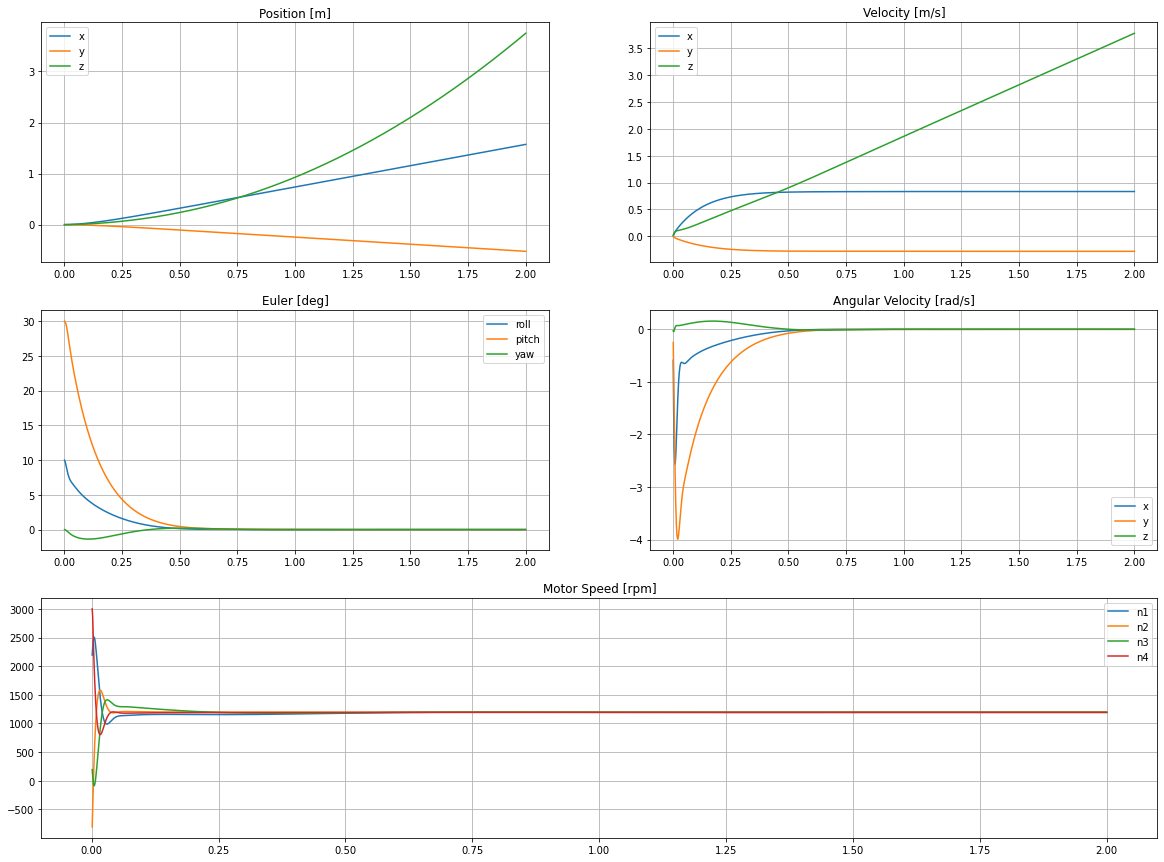

In [325]:
p = []
v = []
w = []
euler = []
for y in yi:
    p.append(y[:3])   # position [m]
    v.append(y[3:6])  # velocity [m/s]
    w.append(y[6:9])  # w [rads/s]
    q = Quaternion(*y[9:])
    euler.append(q.to_euler(True))
v = np.array(v)
w = np.array(w)
p = np.array(p)
ui = np.array(ui)*w2rpm # rad/s -> rpm
euler = np.array(euler)

plt.subplots(figsize=(20,15))

plt.subplot(3,2,1)
plt.plot(ti, p[:,0], label="x")
plt.plot(ti, p[:,1], label="y")
plt.plot(ti, p[:,2], label="z")
plt.legend()
plt.title('Position [m]')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(ti, v[:,0], label="x")
plt.plot(ti, v[:,1], label="y")
plt.plot(ti, v[:,2], label="z")
plt.legend()
plt.title('Velocity [m/s]')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(ti, euler[:,0], label="roll")
plt.plot(ti, euler[:,1], label="pitch")
plt.plot(ti, euler[:,2], label="yaw")
plt.legend()
plt.title('Euler [deg]')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(ti, w[:,0], label="x")
plt.plot(ti, w[:,1], label="y")
plt.plot(ti, w[:,2], label="z")
plt.legend()
plt.title('Angular Velocity [rad/s]')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(ti, ui[:,0], label="n1")
plt.plot(ti, ui[:,1], label="n2")
plt.plot(ti, ui[:,2], label="n3")
plt.plot(ti, ui[:,3], label="n4")
plt.legend()
plt.title('Motor Speed [rpm]')
plt.grid(True)

# plt.subplot(1,3,3)
# plt.plot(ui);

In [231]:
np.zeros(13)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [118]:
m = .429*9.81
print(m)
print(m/params["kf"])

4.20849
5227.937888198758


In [183]:
np.sign(2.344)

1.0